In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pyvi import ViTokenizer
import re

In [1]:
def len_tokenizer(text: str) -> int:
    """Tokenizes the text using the Vietnamese tokenizer."""
    # Placeholder for actual tokenization logic
    return len(text.split())


In [ ]:

parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2500, chunk_overlap=0, 
                                                    separators=[r"[P][Hh][Ầầ][Nn] [0-9IVXLCDM]+[^A-Za-z0-9]", 
                                                                r"[C][Hh][Ưư][Ơơ][Nn][Gg] [0-9IVXLCDM]+[^A-Za-z0-9]",
                                                                r"[M][Ụụ][Cc] [0-9IVXLCDM]+[^A-Za-z0-9]", 
                                                                r'\n (?<!“)(Điều \d+\w*)\. (?![^“]*”)'], 
                                                    is_separator_regex=True, length_function=len_tokenizer)

child_splitter = RecursiveCharacterTextSplitter(chunk_size=255, chunk_overlap=0, 
                                                separators=[r'\n (?<!“)(Điều \d+\w*)\. (?![^“]*”)', 
                                                            r'\n (?<!“)(\d+\w*)\. (?![^“]*”)', 
                                                            r'\n (?<!“)([a-z]+)\) (?![^“]*”)', 
                                                            r'\n', r'\. ', r' '], 
                                                is_separator_regex=True, length_function=len_tokenizer)

### **Law**

In [3]:
import json

with open('Data\doc\law_corpus.json', 'r', encoding='utf-8') as f:
    law_docs = json.load(f)

In [4]:
law_docs[0]

{'metadata': {'title': 'Luật 03/2022/QH15',
  'link': 'https://vbpl.vn/TW/Pages/vbpq-toanvan.aspx?ItemID=152951',
  'description': 'Luật sửa đổi, bổ sung một số điều của Luật Đầu tư công, Luật Đầu tư theo phương thức đối tác công tư, Luật Đầu tư, Luật Nhà ở, Luật Đấu thầu, Luật Điện lực, Luật Doanh nghiệp, Luật Thuế tiêu thụ đặc biệt và Luật Thi hành án dân sự.',
  'ref': 'https://vbpl.vn/TW/Pages/vbpq-vanbanlienquan.aspx?ItemID=152951',
  'attribute': 'https://vbpl.vn/TW/Pages/vbpq-thuoctinh.aspx?ItemID=152951',
  'map': 'https://vbpl.vn/TW/pages/vbpq-luocdo.aspx?ItemID=152951',
  'date_issued': '11/01/2022',
  'effective_date': '01/03/2022',
  'status': 'Hết hiệu lực một phần',
  'id': '152951'},
 'html_data': '<table border="0" class="detailcontent" id="content" width="100%">\n<tr>\n<td colspan="3">\n<div align="justify">\n<p align="center">\n<strong>LUẬT</strong></p>\n<p align="center">\n<strong>SỬA ĐỔI, BỔ SUNG MỘT SỐ ĐIỀU CỦA LUẬT ĐẦU TƯ CÔNG,</strong></p>\n<p align="center">\n<s

In [5]:
law_metadata = {str(doc['metadata']['id']): doc['metadata'] for doc in law_docs}

with open('Data\preprocessed\law_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(law_metadata, f, ensure_ascii=False, indent=4)

In [125]:
parent_pattern = r'\n ((?<!“)Điều \d+)\. '

child_pattern = r'\n (?<!“)(Điều \d+)\. '\
                r'|\n (?<!“)(\d+)\. '\
                r'|\n (?<!“)([a-z]+)\) '

re.findall(parent_pattern, law_docs[0]['data'])

['Điều 1',
 'Điều 2',
 'Điều 3',
 'Điều 4',
 'Điều 5',
 'Điều 6',
 'Điều 7',
 'Điều 8',
 'Điều 9',
 'Điều 10',
 'Điều 11']

In [ ]:
import re
import json

def parse_law_structure(text):
    # Định nghĩa regex để tìm tất cả các mục
    pattern =   r'\n (?<!“)Điều (\d+\w*)\. (?![^“]*”)'\
                r'|\n (?<!“)(\d+\w*)\. (?![^“]*”)'\
                r'|\n (?<!“)([a-z]+)\) (?![^“]*”)'

    matches = re.findall(pattern, text)
    

    # Danh sách (title, loại mục)
    structured_matches = [(m[0] or m[1] or m[2], 
                           "điều" if m[0] else 
                           "khoản" if m[1] else 
                           "điểm") 
                          for m in matches]

    # Khởi tạo cây với một từ điển gốc
    law_tree = {}

    # Biến lưu trạng thái điều, khoản hiện tại
    current_article = None
    current_clause = None

    # Xây dựng cây thư mục từ danh sách đã trích xuất
    for title, kind in structured_matches:
        try:
            if kind == "điều":
                current_article = title
                law_tree[current_article] = {}
                current_clause = None
            elif kind == "khoản":
                current_clause = title
                law_tree[current_article][current_clause] = []
            elif kind == "điểm":
                law_tree[current_article][current_clause].append(title)
        except:
            pass

    return law_tree

parse_law_structure(law_docs[0]['data'])

{'1': {'1': ['a', 'b', 'c'], '2': [], '3': [], '4': []},
 '2': {},
 '3': {'1': [], '2': [], '3': [], '4': [], '5': []},
 '4': {},
 '5': {'1': [], '2': []},
 '6': {'1': [], '2': ['a', 'b']},
 '7': {'1': [], '2': [], '3': ['a', 'b'], '4': [], '5': [], '6': [], '7': []},
 '8': {},
 '9': {'1': [], '2': [], '3': []},
 '10': {},
 '11': {'1': [], '2': [], '3': [], '4': [], '5': []}}

In [7]:
parent_docs = {}
child_docs = []

for doc in law_docs:
    law_id = str(doc['metadata']['id'])
    for i, chunk in enumerate(parent_splitter.split_text(doc['data'])):
        chunk = chunk.strip()
        parent_id = str(doc['metadata']['id']) + '_' + str(i)
        parent_docs[parent_id] = {'id': parent_id, 'law_id': str(doc['metadata']['id']), 
                                  'size': len_tokenizer(chunk), 'content': chunk}
        
        for j, child_chunk in enumerate(child_splitter.split_text(chunk)):
            child_chunk = child_chunk.strip()
            child_id = parent_id + '_' + str(j)
            child_docs.append({'id': child_id, 'parent_id': parent_id, 'law_id': str(doc['metadata']['id']),
                               'size': len_tokenizer(child_chunk), 'content': child_chunk})

with open('Data\preprocessed\law_parent_docs.json', 'w', encoding='utf-8') as f:
    json.dump(parent_docs, f, ensure_ascii=False, indent=4)

with open('Data\preprocessed\law_child_docs.json', 'w', encoding='utf-8') as f:
    json.dump(child_docs, f, ensure_ascii=False, indent=4)

In [ ]:
parent_tokennized_docs = {}
child_tokennized_docs = []

for doc in law_docs:
    law_id = str(doc['metadata']['id'])
    doc_tokenized = ViTokenizer.tokenize(doc['data'])
    for i, chunk in enumerate(parent_splitter.split_text(doc_tokenized)):
        chunk = chunk.strip()
        parent_id = str(doc['metadata']['id']) + '_' + str(i)
        parent_tokennized_docs[parent_id] = {'id': parent_id, 'law_id': str(doc['metadata']['id']), 
                                  'size': len_tokenizer(chunk), 'content': chunk}
        
        for j, child_chunk in enumerate(child_splitter.split_text(chunk)):
            child_chunk = child_chunk.strip()
            child_id = parent_id + '_' + str(j)
            child_tokennized_docs.append({'id': child_id, 'parent_id': parent_id, 
                                          'law_id': str(doc['metadata']['id']), 
                                          'size': len_tokenizer(child_chunk), 'content': child_chunk})


with open('Data\preprocessed\law_parent_tokennized_docs.json', 'w', encoding='utf-8') as f:
    json.dump(parent_tokennized_docs, f, ensure_ascii=False, indent=4)

with open('Data\preprocessed\law_child_tokennized_docs.json', 'w', encoding='utf-8') as f:
    json.dump(child_tokennized_docs, f, ensure_ascii=False, indent=4)

### **Q&A**

In [2]:
import json

with open('Data\Q&A\q&a_dataset_prefiltered.json', 'r', encoding='utf-8') as f:
    qa_data = json.load(f)

In [3]:
qa_dataset = []
q_lens = []
a_lens = []

c = 0

for item in qa_data:
    for qa in item['samples']:
        q_lens.append(len_tokenizer(qa['query']))
        a_lens.append(len_tokenizer(qa['pos']))
        if qa['query'].strip()[0].isupper() or qa['query'].strip()[0].isdigit() or qa['query'].strip()[0] in ['*', '-'] or '?' in qa['query']:
            qa_dataset.append({'query': qa['query'].replace('\n', ' '), 'pos': qa['pos'].replace('\n', ' ')})


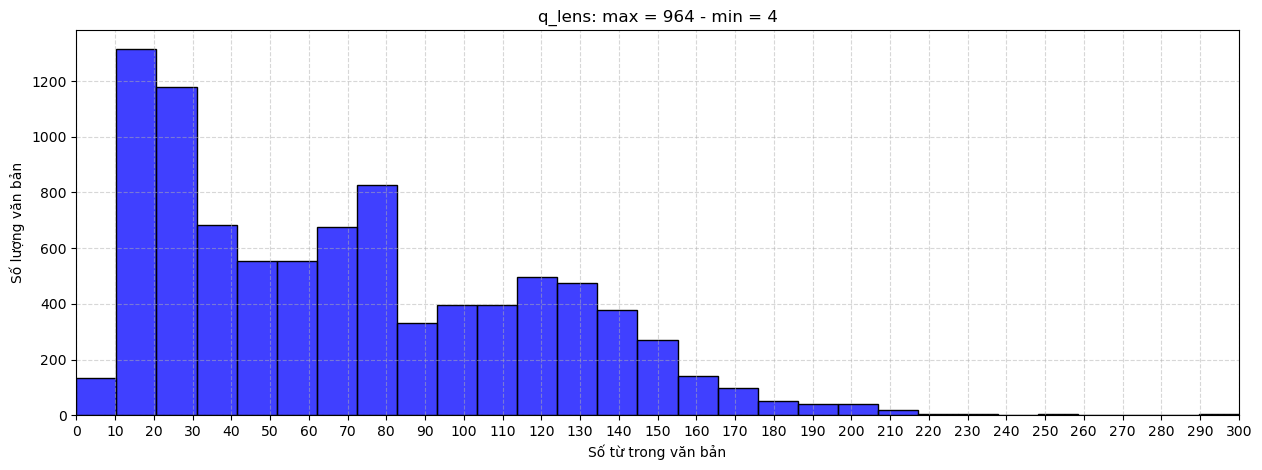

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

bins = np.linspace(0, 300, num=30)  

# Vẽ histogram
plt.figure(figsize=(15, 5))
sns.histplot(q_lens, bins=bins, kde=False, color="blue")

# Cấu hình biểu đồ
plt.xlim(0, 300)
plt.xticks(np.arange(0, 301, step=10))
plt.xlabel("Số từ trong văn bản")
plt.ylabel("Số lượng văn bản")
plt.grid(True, linestyle="--", alpha=0.5)
plt.title('q_lens: max = ' + str(np.max(q_lens)) + ' - min = ' + str(np.min(q_lens)))

# Hiển thị biểu đồ
plt.show()

In [158]:
np.sum(np.array(q_lens) > 128)

1351

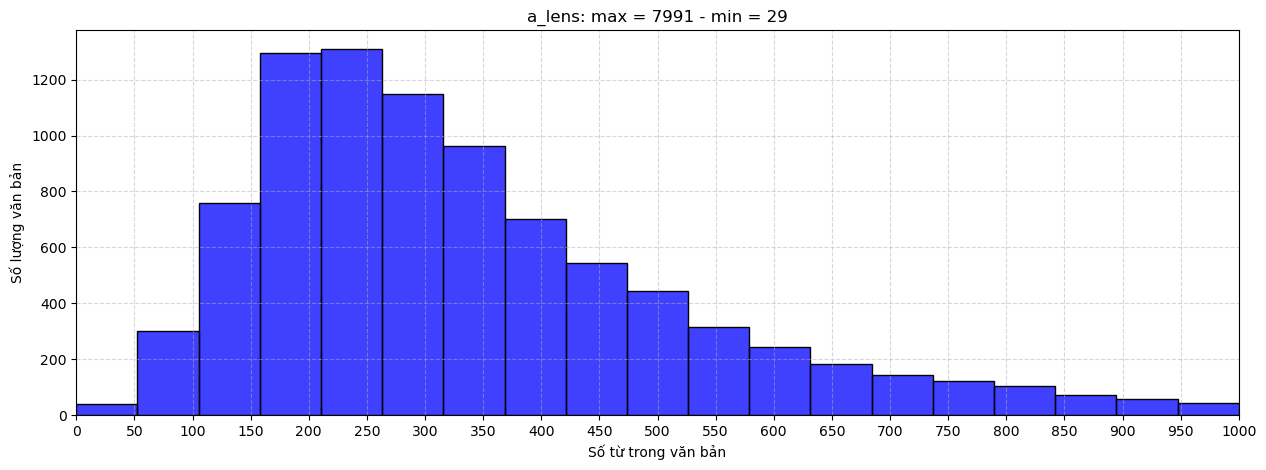

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

bins = np.linspace(0, 1000, num=20)  

# Vẽ histogram
plt.figure(figsize=(15, 5))
sns.histplot(a_lens, bins=bins, kde=False, color="blue")

# Cấu hình biểu đồ
plt.xlim(0, 1000)
plt.xticks(np.arange(0, 1001, step=50))
plt.xlabel("Số từ trong văn bản")
plt.ylabel("Số lượng văn bản")
plt.grid(True, linestyle="--", alpha=0.5)
plt.title('a_lens: max = ' + str(np.max(a_lens)) + ' - min = ' + str(np.min(a_lens)))

# Hiển thị biểu đồ
plt.show()

In [149]:
len(a_lens)

9090

In [150]:
np.sum(np.array(a_lens) < 512)

7389

In [151]:
np.sum(np.array(a_lens) > 1024)

277

In [4]:
qa_dataset = [qa for qa in qa_dataset if len_tokenizer(qa['query']) < 256 and len_tokenizer(qa['pos']) < 768]
len(qa_dataset)

8282

In [5]:
import random

random.shuffle(qa_dataset)

test = qa_dataset[:2000]

len_train = len(qa_dataset[2000:])

In [7]:
train = []

for i, item in enumerate(qa_dataset[2000:]):
    item_train = item.copy()
    while True:
        indices = random.sample(range(len_train), 13)
        if i not in indices:
            break
    item_train['pos'] = [item['pos']]
    item_train['neg'] = [qa_dataset[2000 + j]['pos'] for j in indices]

    train.append(item_train)

train[0]

{'query': 'Quyền đối với vốn và tài sản của Tổng công ty Đường sắt Việt Nam được quy định như thế nào? Xin chào Ban biên tập. Tôi có một thắc mắc, mong được ban biên tập tư vấn giúp. Quyền đối với vốn và tài sản của Tổng công ty Đường sắt Việt Nam được quy định như thế nào? Văn bản nào quy định điều này? Mong nhận được câu trả lời từ Ban biên tập. Tôi xin chân thành cám ơn Ban biên tập Thư Ký Luật! Thành An (an****@gmail.com)',
 'pos': ['Quyền đối với vốn và tài sản của Tổng công ty Đường sắt Việt Nam được quy định tại Điều 10 Nghị định 175/2013/NĐ-CP Điều lệ tổ chức và hoạt động của Tổng công ty Đường sắt Việt Nam và được sửa đổi bởi Nghị định 69/2015/NĐ-CP như sau:   1. Chiếm hữu, sử dụng, định đoạt vốn và tài sản của Tổng công ty Đường sắt Việt Nam để kinh doanh, thực hiện các lợi ích hợp pháp từ vốn và tài sản của Tổng công ty Đường sắt Việt Nam theo quy định của pháp luật.   2. Quản lý và sử dụng các tài sản là đất đai, tài nguyên do Nhà nước đầu tư, cho thuê theo quy định của phá

In [8]:
import json

with open("Data/train.jsonl", "w", encoding="utf-8") as f:
    for item in train:
        json.dump(item, f, ensure_ascii=False)
        f.write("\n")

In [9]:
with open('Data/test.json', 'w', encoding='utf-8') as f:
    json.dump(test, f, ensure_ascii=False, indent=4)